# Data exploration - Sea Level 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels as sm
from datetime import timedelta, datetime

The dataset contains Global Mean Sea Level (GMSL) variations compared to the 20 year collinear mean reference from year 1996 - 2016

In [2]:
header_names = ['Type', 'Index', 'Year', 'nOfObs', 'nOfWObs', 'GMSL1', 'stdGMSL1', 'smGMSL1',
                'GMSL2', 'stdGMSL2', 'smGMSL2', 'smGMSL3']
raw_data = pd.read_csv('HDR Global Mean Sea Level Data.txt', sep = "\n", skiprows = 49)
raw_data.head()

,HDR Header_End---------------------------------------
0,0 11 1993.0115260 466462 337277.00 ...
1,0 12 1993.0386920 460889 334037.31 ...
2,0 13 1993.0658580 472123 342416.09 ...
3,0 14 1993.0930250 421377 306050.59 ...
4,0 15 1993.1201910 459548 331094.09 ...


In [3]:
raw_data.columns = ['Lines']
df = raw_data['Lines'].str.split(n = 12, expand=True)
df.columns = header_names
df = df.astype(float)
df = df.astype({'nOfObs': int})
df.head()

,Type,Index,Year,nOfObs,nOfWObs,GMSL1,stdGMSL1,smGMSL1,GMSL2,stdGMSL2,smGMSL2,smGMSL3
0,0.0,11.0,1993.011526,466462,337277.00,-37.24,92.66,-37.02,-37.24,92.66,-37.02,-37.55
1,0.0,12.0,1993.038692,460889,334037.31,-40.35,95.39,-38.20,-40.34,95.39,-38.19,-38.06
2,0.0,13.0,1993.065858,472123,342416.09,-40.17,92.29,-38.28,-40.16,92.29,-38.27,-37.60
3,0.0,14.0,1993.093025,421377,306050.59,-41.92,96.20,-38.56,-41.89,96.19,-38.54,-37.45
4,0.0,15.0,1993.120191,459548,331094.09,-36.89,94.64,-37.87,-36.85,94.63,-37.83,-36.44


In [4]:
def is_leap(year):
    return year % 4 == 0 and year % 100 != 0 and year % 400 == 0
def convert_partial_year(number):
    year = int(number)
    d = timedelta(days=(number - year)*(365 + is_leap(year)))
    day_one = datetime(year,1,1)
    date = d + day_one
    return date

In [5]:
#df['Year'] = df['Year'].apply(convert_partial_year)
#df.head()

## Plotting
Let's plot a time series of GMSL2 and smGMSL3. GMSL2 is GMSL with Global Isostatic Adjustment (GIA) applied. smGMSL3 is smoothed GMSL2 with annual and semi-annual signals removed

In [6]:
df1 = df[['Year','GMSL2','smGMSL3']]
df1 = df1.set_index('Year')
df1.head()

,GMSL2,smGMSL3
Year,,
1993.011526,-37.24,-37.55
1993.038692,-40.34,-38.06
1993.065858,-40.16,-37.60
1993.093025,-41.89,-37.45
1993.120191,-36.85,-36.44


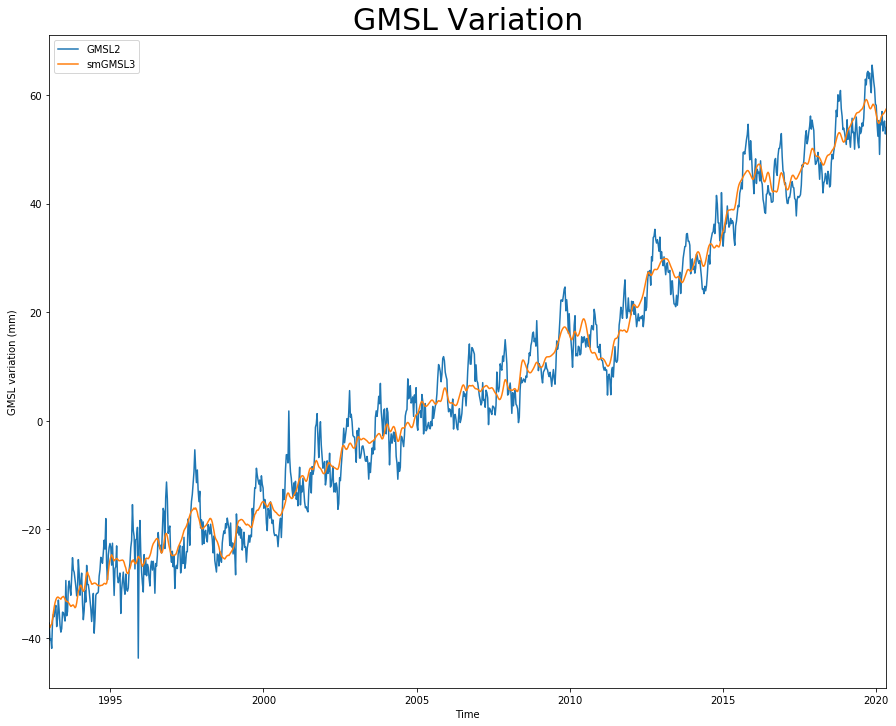

In [7]:
df1.plot(figsize = (15,12), linewidth = 1.5)
plt.xlabel('Time')
plt.ylabel('GMSL variation (mm)')
plt.title('GMSL Variation', fontsize = 30)
plt.show()

In [8]:
import plotly.graph_objs as go
import plotly.express as ex
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [9]:
#df1.iplot(kind='line', xTitle='Time (years)', 
#          yTitle='GMSL (mm)', title='Global Mean Sea Level (mm)', width = 1.5)

In [10]:
fig = go.Figure( layout=go.Layout(
        xaxis=dict(title = "Year", color = 'black'),
        yaxis=dict(title = "GMSL variation (mm)", color = 'black'),
    ))

fig.add_trace(go.Scatter(
                x=df1.index,
                y=df1['GMSL2'],
                name="GMSL2",
                line_color= 'rgb(256, 150, 8)', line_width = 1.5,
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=df1.index,
                y=df1['smGMSL3'],
                name="smGMSL3",
                line_color='rgb(50, 100, 185)', line_width = 1.5,
                opacity=0.8))

# Use date string to set xaxis range
fig.update_layout(title_text = "Global mean sea level (mm)", title_x=0.5, title_font_size = 22,
                  paper_bgcolor = 'rgb(245, 246, 250)', plot_bgcolor = 'rgb(245, 246, 250)')
fig.show()

## Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
x = df1.index.values.reshape(-1, 1) 
y_GMSL2 = df1.iloc[:,0]
y_smGMSL3 = df1.iloc[:,1]

In [13]:
x.flatten()[-1]

2020.323351

In [14]:
LR = LinearRegression()
LR.fit(x, y_GMSL2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
def generate_year(start_year, end_year):
    step = 0.05
    year_list = []
    while (start_year < end_year):
        start_year += step
        year_list.append(start_year)
    return year_list

In [16]:
x_futureyears = np.array(generate_year(x.flatten()[-1], 2030)).reshape(-1, 1)
pred = LR.predict(x_futureyears)
df3 = pd.DataFrame(data = x_futureyears, columns = ['Year'])
df3['GMSL2_pred'] = pred

In [17]:
fig = go.Figure( layout=go.Layout(        xaxis=dict(title = "Year", color = 'black'),
        yaxis=dict(title = "GMSL variation (mm)", color = 'black'),
    ))

fig.add_trace(go.Scatter(
                x=df1.index,
                y=df1['GMSL2'],
                name="GMSL2",
                line_color= 'rgb(256, 150, 8)', line_width = 1.5,
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=df1.index,
                y=df1['smGMSL3'],
                name="smGMSL3",
                line_color='rgb(50, 100, 185)', line_width = 1.5,
                opacity=0.8))
fig.add_trace(go.Scatter(
                x=df3.Year,
                y=df1['GMSL2'].tail(1).append(df3['GMSL2_pred']),
                name="GMSL_pred",
                line_width = 1.5,
                opacity=0.8))

# Use date string to set xaxis range
fig.update_layout(title_text = "Global mean sea level (mm)", title_x=0.5, title_font_size = 22,
                  paper_bgcolor = 'rgb(245, 246, 250)', plot_bgcolor = 'rgb(245, 246, 250)')
fig.show()

## Polynomial linear regression

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
poly_features = PolynomialFeatures(degree = 2)
x_poly = poly_features.fit_transform(x)
x_futureyears_poly = poly_features.fit_transform(x_futureyears)
LR.fit(x_poly, y_GMSL2)
poly_pred = LR.predict(x_futureyears_poly)
df3['GMSL2_poly_pred'] = poly_pred

In [21]:
fig = go.Figure( layout=go.Layout(xaxis=dict(title = "Year", color = 'black'),
        yaxis=dict(title = "GMSL variation (mm)", color = 'black'),
    ))

fig.add_trace(go.Scatter(
                x=df1.index,
                y=df1['GMSL2'],
                name="GMSL2",
                line_color= 'rgb(256, 150, 8)', line_width = 1.5,
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=df1.index,
                y=df1['smGMSL3'],
                name="smGMSL3",
                line_color='rgb(50, 100, 185)', line_width = 1.5,
                opacity=0.8))
fig.add_trace(go.Scatter(
                x=df3.Year,
                y=df1['GMSL2'].tail(1).append(df3['GMSL2_pred']),
                name="GMSL_pred",
                line_width = 1.5,
                opacity=0.8))
fig.add_trace(go.Scatter(
                x=df3.Year,
                y=df1['GMSL2'].tail(1).append(df3['GMSL2_poly_pred']),
                name="GMSL_pred",
                line_width = 1.5,
                opacity=0.8))

# Use date string to set xaxis range
fig.update_layout(title_text = "Global mean sea level variation (mm)", title_x=0.5, title_font_size = 22,
                  paper_bgcolor = 'rgb(245, 246, 250)', plot_bgcolor = 'rgb(245, 246, 250)')
fig.show()